## Import Libraries

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

-------------------------------------------------------------------------------------------------------------------------------

## Load and Inspect Data

In [2]:
data = pd.read_csv("insurance.txt")
data.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   bmi       1338 non-null   float64
 2   children  1338 non-null   int64  
 3   charges   1338 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 41.9 KB


In [4]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


-------------------------------------------------------------------------------------------------------------------------------

## Preprocess Data

__The purpose of the following preprocessing is to demonstrate that the employed method is functioning correctly. However, while building regression models, the training and testing datasets are standardised separately to prevent data leakage.__

In [5]:
column_names = list(data.columns)
standardize = lambda x : (x - x.mean()) / x.std() 

__Standardize Data__

In [6]:
for column in column_names:
    if column == "charges":
        continue
    data[column] = standardize(data[column])

In [7]:
data.mean()

age        -1.246304e-16
bmi        -1.810543e-16
children   -3.116590e-16
charges     1.327042e+04
dtype: float64

Although standardised mean should be equal to 0, in reality they are infinitesimally close to zero. Double precision floats have 53 bits or 16 digits of precision, so this is expected behavior.

In [8]:
data.std()

age             1.000000
bmi             1.000000
children        1.000000
charges     12110.011237
dtype: float64

In [9]:
x1, x2, x3, y = data["age"], data["bmi"], data["children"], data["charges"]

-------------------------------------------------------------------------------------------------------------------------------

## Visualize Data

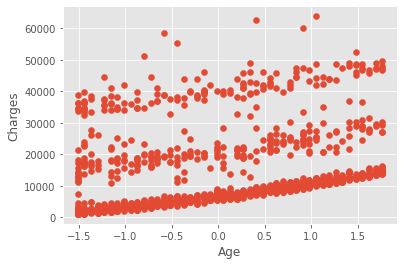

In [10]:
plt.scatter(x1, y)
plt.xlabel("Age")
plt.ylabel("Charges");

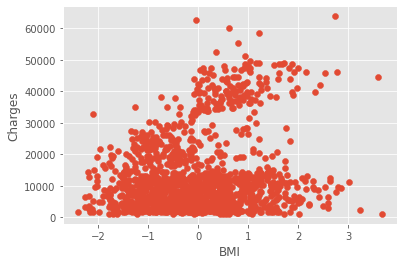

In [11]:
plt.scatter(x2, y)
plt.xlabel("BMI")
plt.ylabel("Charges");

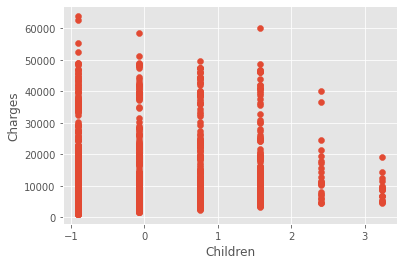

In [12]:
plt.scatter(x3, y)
plt.xlabel("Children")
plt.ylabel("Charges");

-------------------------------------------------------------------------------------------------------------------------------

## Linear Regression Algorithms

### Linear Regression by Solving Normal Equations

$y = w_{0} + w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{3}$

$x_{1}, x_{2}, x_{3}$ represent the age, bmi and number of children respectively. $ w_{1},w_{2}, w_{3}$ are weights associated with $x_{1}, x_{2}, x_{3}$.

$$X = 
\begin{bmatrix} 
1 & x_{11} & x_{12} & x_{13}\\
1 & x_{21} & x_{22} & x_{23}\\
. & . & . & . \\
. & . & . & . \\
1 & x_{m1} & x_{m2} & x_{m3}\\
\end{bmatrix}
\quad
$$
$$ $$
$$Y = 
\begin{bmatrix} 
y_{1}\\
y_{2}\\
.\\
.\\
y_{m}\\
\end{bmatrix}
\quad
$$ where $m$ = size of training data
$$ $$
$$ω = 
\begin{bmatrix} 
ω_{0}\\
ω_{1}\\
ω_{2}\\
ω_{3}\\
\end{bmatrix}
\quad
$$
$$ $$
$$b = X^{T} . Y$$

$$ ω = (X^{T}.X)^{-1}x^{T}.Y = (X^{T}.X)^{-1}.b$$

### Linear Regression by Gradient Descent

$$
E(ω) = 
\begin{equation}
\frac{1}{2} * \sum_{n=0}^{N} (x_{n}*ω - y_{n})^{2} 
\end{equation}
$$
$$ $$
$$Sum of Squares of Errors$$
$$ $$
$$ 
\begin{equation}
\frac{\partial E(ω)}{\partial ω} = (X.ω - Y).X
\end{equation}
$$
$$ $$
$$ Gradient$$
$$ $$
$$
ω = ω - η * \frac{\partial E(ω)}{\partial ω}
$$
$$ $$
where $η$ is the learning rate

### Linear Regression by Stochastic Gradient Descent

SGD makes sequential passes over the training data, and during each pass, updates feature weights one example at a time with the aim of approaching the optimal weights that minimize the loss.

$$ 
\begin{equation}
\frac{\partial E(ω)}{\partial ω}_{ω=ω_{n}} = (x_{n}.ω_{n} - y_{n}).x_{n}
\end{equation}
$$
$$ $$
$$ Gradient$$
$$ $$
$$
ω = ω - η * \frac{\partial E(ω)}{\partial ω}_{ω = w_{n}}
$$
$$ $$
where $η$ is the learning rate

In [13]:
class LinearRegression:
    def __init__(self, data):
        self.data = data
        self.models1 = pd.DataFrame(columns = ["w0", "w1", "w2", "w3", "testing_error", "training_error"])
        self.models2 = pd.DataFrame(columns = ["w0", "w1", "w2", "w3", "testing_error", "training_error", "iterations"])
        self.models3 = pd.DataFrame(columns = ["w0", "w1", "w2", "w3", "testing_error", "training_error", "iterations"])
        self.errors2 = []
        self.errors3 = []
    
    # shuffles data randomly
    def shuffle(self):
        self.data = self.data.sample(frac = 1)
    
    # splits a data frame in 70:30 ratio
    def split(self):
        train = self.data[:int(0.7 * len(data))]
        test = self.data[int(0.7 * len(data)):]
        return train, test
    
    # standardizes data
    def standardize(self, data):
        column_names = list(data.columns)
        standardize = lambda x : (x - x.mean()) / x.std()
        for column in column_names:
            if column == "charges":
                continue
            data[column] = standardize(data[column])
        return data
    
    # computes and returns X and Y matrices
    def matrices(self, train):
        x1, x2, x3, y = train["age"], train["bmi"], train["children"], train["charges"]
        x1, x2, x3= np.array(x1), np.array(x2), np.array(x3)
        Y = np.array(y)
        n = len(Y)
        Y = Y.reshape((n, 1))
        x0 = np.ones((n,1))
        x1 = np.reshape(x1, (n, 1))
        x2 = np.reshape(x2, (n, 1))
        x3 = np.reshape(x3, (n, 1))
        X = np.append(x0, x1, axis=1)
        X = np.append(X, x2, axis=1)
        X = np.append(X, x3, axis=1)
        return X, Y
    
    # Sum of Squares Error Function
    def error(self, X, Y, w):
        Y_pred = np.dot(X, w)
        mse = (1/2) * np.sum(np.square(Y_pred-Y))
        return float(mse)
    
    # tests the model against testing data
    def testModel(self, test, w):
        Xt, Yt = self.matrices(test)
        testing_error = self.error(Xt, Yt, w)
        return testing_error
           
    # Performs Linear Regression by Normal Equations and returns corresponding Regression Weights
    def solve(self, X, Y):
        XT = np.transpose(X)
        A = XT.dot(X)
        A_inv = np.linalg.inv(A)
        b = XT.dot(Y)
        w = A_inv.dot(b)
        return w

    # Implements Gradient Descent Algorithm
    def gradientDescent(self, X, Y, w, learning_rate = 1e-7):
        i = 1
        errors = []
        error, prev_error = float("inf"), 0
        while abs(prev_error-error) > 1e-5:
            prev_error = error
            Y_pred = X.dot(w)
            gradient = np.dot(X.transpose(), Y_pred- Y)
            w -= learning_rate * gradient
            error = self.error(X, Y, w)
            errors.append(error)
            i+=1
        return w, errors, i

    # Implements Stochastic Gradient Descent Algorithm
    def stochasticGradientDescent(self, X, Y, w, learning_rate = 1e-5):
        m, i = len(Y), 0
        errors = []
        error, prev_error = float("inf"), 0
        while abs(prev_error-error) > 1e-2:
            prev_error = error
            x = X[i%m].reshape(1, 4)
            y = Y[i%m].reshape(1, 1)
            y_pred = x.dot(w)
            gradient = np.dot(x.transpose(), y_pred- y)
            w -= learning_rate * gradient
            error = self.error(X, Y, w)
            errors.append(error)
            i+=1
        return w, errors, i + 1

    # main function to build models
    def buildModels(self, number = 20):
        for i in range(number):
            self.shuffle()                                                                  # shuffle dataset
            train, test = self.split()                                                      # split dataset
            train = self.standardize(train)                                                 # standardise training data
            test = self.standardize(test)                                                   # standardise testing data
            X, Y = self.matrices(train)                                                     # obtain X and Y matrices
            w1 = self.solve(X, Y)                                                           # regression by normal equations
            w2 = np.random.rand(4, 1)                                                       # generate random weights w for grad. desc.
            w2, model_errors2 , iterations2 = self.gradientDescent(X, Y, w2)                # regression by gradient descent
            w3 = np.random.rand(4, 1)                                                       # generate random weights w for st. grad. desc.
            w3, model_errors3 , iterations3 = self.stochasticGradientDescent(X, Y, w3)      # regression by stochastic grad. desc.
            training_error1 = self.error(X, Y, w1)                                          # calculate training error
            training_error2 = self.error(X, Y, w2)                                          # calculate training error
            training_error3 = self.error(X, Y, w3)                                          # calculate training error
            testing_error1 = self.testModel(test, w1)                                       # calculate testing error
            testing_error2 = self.testModel(test, w2)                                       # calculate testing error
            testing_error3 = self.testModel(test, w3)                                       # calculate testing error
            # append the model, errors to models dataframe
            model1 = list(w1)
            model2 = list(w2)
            model3 = list(w3)
            model1.append(testing_error1)
            model2.append(testing_error2)
            model3.append(testing_error3)
            model1.append(training_error1)
            model2.append(training_error2)
            model3.append(training_error3)
            model2.append(iterations2)
            model3.append(iterations3)
            model1 = pd.Series(model1, index = self.models1.columns)
            model2 = pd.Series(model2, index = self.models2.columns)
            model3 = pd.Series(model3, index = self.models3.columns)
            self.models1 = self.models1.append(model1, ignore_index=True)
            self.models2 = self.models2.append(model2, ignore_index=True)
            self.models3 = self.models3.append(model3, ignore_index=True)
            self.errors2.append(model_errors2)
            self.errors3.append(model_errors3)

-------------------------------------------------------------------------------------------------------------------------------

## Build Regression Models

In [14]:
data = pd.read_csv("insurance.txt")

In [15]:
lr_models = LinearRegression(data)
lr_models.buildModels(20)

In [16]:
lr_models.models1

,w0,w1,w2,w3,testing_error,training_error
0,[12785.7209692938],[3218.4308448869438],[1993.2949363807866],[833.8292579290325],2.774383e+10,5.855827e+10
1,[13187.06869228525],[3655.8024947155827],[2008.7161689542515],[596.1470129798473],2.612396e+10,6.006470e+10
2,[13450.890631911323],[3264.500405752952],[2465.5630849391137],[715.8020676746733],2.466853e+10,6.155293e+10
3,[13088.950621676291],[2871.0850774314767],[2323.126347195842],[750.7138231612689],2.761109e+10,5.877664e+10
4,[13147.564093867528],[3218.7719719666884],[1840.4360924001],[858.5726679032239],2.702176e+10,5.920699e+10
5,[13234.643741987184],[3243.6525720163067],[2438.7277512552573],[538.8411765290195],2.606549e+10,6.008189e+10
6,[13644.61580239209],[3419.7076315207555],[2060.842077302632],[336.6820857761744],2.538624e+10,6.097637e+10
7,[13044.110772125005],[3008.3274683457753],[2417.0591750705653],[708.1011841097376],2.698067e+10,5.935671e+10
8,[13189.895961110044],[3494.2161390661613],[1809.312776045806],[954.0928003685109],2.740359e+10,5.882282e+10
9,[13254.829052637828],[3335.352174326074],[2154.731456845511],[410.5460427487169],2.573493e+10,6.043877e+10


In [17]:
lr_models.models2

,w0,w1,w2,w3,testing_error,training_error,iterations
0,[12785.704806958458],[3218.4267587211043],[1993.2975738164735],[833.8302584963193],2.774384e+10,5.855827e+10,145092
1,[13187.054830291276],[3655.7953035339015],[2008.7206140077694],[596.1514484517481],2.612396e+10,6.006470e+10,147062
2,[13450.874615936287],[3264.496730886144],[2465.5657704121413],[715.8028777959819],2.466853e+10,6.155293e+10,145731
3,[13088.934544362737],[2871.0823031421046],[2323.1267086526686],[750.7158517659404],2.761110e+10,5.877664e+10,145398
4,[13147.548664057944],[3218.766138599871],[1840.441154464836],[858.5721127759415],2.702176e+10,5.920699e+10,145885
5,[13234.627356482984],[3243.649609527797],[2438.7287766834343],[538.8417565534571],2.606549e+10,6.008189e+10,145314
6,[13644.59949108557],[3419.7027274214815],[2060.845370048979],[336.68288717051263],2.538623e+10,6.097637e+10,145688
7,[13044.095490370457],[3008.324615662804],[2417.05941783423],[708.1033650832742],2.698067e+10,5.935671e+10,145904
8,[13189.880570875705],[3494.2123239921043],[1809.314238239843],[954.0935773477859],2.740359e+10,5.882282e+10,145947
9,[13254.813564462345],[3335.347761690922],[2154.7346578298316],[410.5463477787721],2.573493e+10,6.043877e+10,145932


In [18]:
lr_models.models3

,w0,w1,w2,w3,testing_error,training_error,iterations
0,[12716.838208221132],[3207.6691465779218],[1990.6188464513657],[832.168930110985],2.779172e+10,5.856055e+10,523637
1,[13183.18520136311],[3655.733303109121],[2008.6390157031985],[597.5618920145848],2.612430e+10,6.006470e+10,808746
2,[13447.588116084431],[3265.880733509023],[2463.5155191760823],[714.6613544565416],2.466651e+10,6.155294e+10,848129
3,[13088.292890707191],[2870.0662656455106],[2324.436496014601],[750.7804725464691],2.761221e+10,5.877664e+10,904197
4,[13143.074358668775],[3216.7795761512825],[1839.3106374606448],[855.9585490868212],2.702265e+10,5.920701e+10,799093
5,[13226.745983061795],[3242.683249542699],[2438.2115749358077],[539.2518208648563],2.606572e+10,6.008192e+10,745692
6,[13639.299584194392],[3418.091227829294],[2059.6916287044896],[337.06012083247134],2.538335e+10,6.097639e+10,778441
7,[13037.333307618599],[3008.30145242029],[2415.4571575637115],[708.5987946575852],2.698213e+10,5.935673e+10,759147
8,[13182.435206796592],[3491.07184041248],[1806.99445693432],[951.8777957313948],2.740381e+10,5.882285e+10,766482
9,[13250.191297202527],[3334.250799886082],[2156.021723456456],[411.9697538069722],2.573479e+10,6.043879e+10,775159


### Describe Regression Models

In [19]:
lr_models.models1.describe()

,testing_error,training_error
count,2.000000e+01,2.000000e+01
mean,2.660708e+10,5.964760e+10
std,1.645346e+09,1.599378e+09
min,2.362015e+10,5.653452e+10
25%,2.564776e+10,5.872204e+10
50%,2.655231e+10,5.971070e+10
75%,2.764428e+10,6.060359e+10
max,2.983967e+10,6.256008e+10


In [20]:
lr_models.models2.describe()

,testing_error,training_error
count,2.000000e+01,2.000000e+01
mean,2.660708e+10,5.964760e+10
std,1.645349e+09,1.599378e+09
min,2.362015e+10,5.653452e+10
25%,2.564776e+10,5.872204e+10
50%,2.655232e+10,5.971070e+10
75%,2.764428e+10,6.060359e+10
max,2.983967e+10,6.256008e+10


In [21]:
lr_models.models3.describe()

,testing_error,training_error
count,2.000000e+01,2.000000e+01
mean,2.660964e+10,5.964775e+10
std,1.647685e+09,1.599310e+09
min,2.362017e+10,5.653452e+10
25%,2.564693e+10,5.872262e+10
50%,2.655322e+10,5.971072e+10
75%,2.765709e+10,6.060359e+10
max,2.983947e+10,6.256010e+10


### Training Error

__Normal Equations__

In [22]:
print(f"Mean of training error obtained over 20 regression models = {lr_models.models1.training_error.mean()}")

Mean of training error obtained over 20 regression models = 59647597431.33492


In [23]:
print(f"Minimum training error obtained over 20 regression models = {lr_models.models1.training_error.min()}")

Minimum training error obtained over 20 regression models = 56534523919.390465


__Gradient Descent__

In [24]:
print(f"Mean of training error obtained over 20 regression models = {lr_models.models2.training_error.mean()}")

Mean of training error obtained over 20 regression models = 59647597431.46159


In [25]:
print(f"Minimum training error obtained over 20 regression models = {lr_models.models2.training_error.min()}")

Minimum training error obtained over 20 regression models = 56534523919.52552


__Stochastic Gradient Descent__

In [26]:
print(f"Mean of training error obtained over 20 regression models = {lr_models.models3.training_error.mean()}")

Mean of training error obtained over 20 regression models = 59647754829.26682


In [27]:
print(f"Minimum training error obtained over 20 regression models = {lr_models.models3.training_error.min()}")

Minimum training error obtained over 20 regression models = 56534524598.4773


### Testing Error

__Normal Equations__

In [28]:
print(f"Mean of testing error obtained over 20 regression models = {lr_models.models1.testing_error.mean()}")

Mean of testing error obtained over 20 regression models = 26607080060.292473


In [29]:
print(f"Minimum testing error obtained over 20 regression models = {lr_models.models1.testing_error.min()}")

Minimum testing error obtained over 20 regression models = 23620151155.09215


__Gradient Descent__

In [30]:
print(f"Mean of testing error obtained over 20 regression models = {lr_models.models2.testing_error.mean()}")

Mean of testing error obtained over 20 regression models = 26607081449.48668


In [31]:
print(f"Minimum testing error obtained over 20 regression models = {lr_models.models2.testing_error.min()}")

Minimum testing error obtained over 20 regression models = 23620148955.51576


__Stochastic Gradient Descent__

In [32]:
print(f"Mean of testing error obtained over 20 regression models = {lr_models.models3.testing_error.mean()}")

Mean of testing error obtained over 20 regression models = 26609644311.551937


In [33]:
print(f"Minimum testing error obtained over 20 regression models = {lr_models.models3.testing_error.min()}")

Minimum testing error obtained over 20 regression models = 23620173673.723877


-------------------------------------------------------------------------------------------------------------------------------

## Plot the Convergence

__Plot $E(\omega)$ against the number of iterations of Gradient Descent__

In [34]:
errorsGD = np.array(lr_models.errors2, dtype=object)

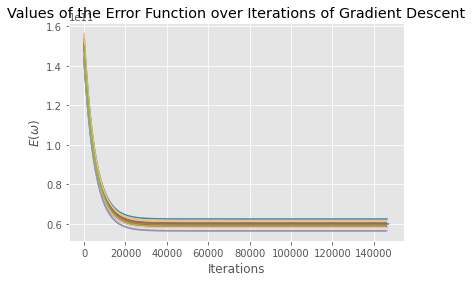

In [35]:
for error in errorsGD:
    plt.plot(error)
    plt.xlabel("Iterations")
    plt.ylabel("$E(\omega)$")
    plt.title("Values of the Error Function over Iterations of Gradient Descent");

__Plot $E(\omega)$ against the number of iterations of Stochastic Gradient Descent__

In [36]:
errorsSGD = np.array(lr_models.errors3, dtype=object)

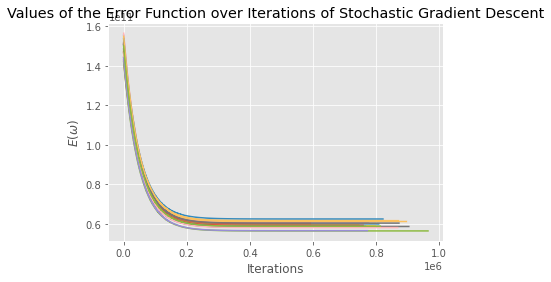

In [37]:
for error in errorsSGD:
    plt.plot(error)
    plt.xlabel("Iterations")
    plt.ylabel("$E(\omega)$")
    plt.title("Values of the Error Function over Iterations of Stochastic Gradient Descent");

-------------------------------------------------------------------------------------------------------------------------------